In [36]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt,mpld3
%matplotlib inline 

from shapely.geometry import Polygon,mapping 
import geopandas as gpd
import folium 

In [37]:
#select from NYSE,NASDAQ, unemployment_rate
def modify_result1(user_input):
    #Get COVID data
#     cur.callproc("get_COVID_data")
#     db_connection.commit()
    
#     election = pd.read_sql("select * from result;", con=db_connection)
    cases = pd.read_csv("./resources/COVID_Cases.csv" )
    if(user_input == "unemployment_rate"):
        #     cur.callproc("get_unemployment_rate")
        #     db_connection.commit()
        #     election = pd.read_sql("select * from result;", con=db_connection)
        user_input = pd.read_csv("State_Unemployment_Rate.csv")
        #print("here")
    if(user_input == "NYSE"):
        #     cur.callproc("monthly_NYSE_info")
        #     db_connection.commit()
        #     election = pd.read_sql("select * from result;", con=db_connection)
        user_input = pd.read_csv("./resources/monthly_NYSE_info.csv")
    if(user_input == "NASDAQ"):
        #     cur.callproc("monthly_NASDAQ_info")
        #     db_connection.commit()
        #     election = pd.read_sql("select * from result;", con=db_connection)
        user_input = pd.read_csv("./resources/monthly_NYSE_info.csv")
        
    # Transform election data 
    states = set(cases['state'])
    months = set(cases['month'])

    results1 = {}
    for state in states:
    
        result1 = {}
        for month in months:
            positive = cases[(cases.month == month) & (cases.state == state)]['positive'].values
            if(positive.size == 0):
                pos = 0
            else:
                pos = positive[0]
            if(user_input == "unemployment_rate"):
                rate = user_input[(user_input.Month == month) & (user_input.State == state)]['Unemploy_rate '].values *1000
                if(rate.size == 0):
                    rate1 = 0
                else:
                    rate1 = rate[0]
        
                result1[month] = {'pos':pos,'rate':rate1}
            if(user_input == "NYSE" | user_input == "NASDAQ"):
                rate = user_input[(user_input.Month == month) & (user_input.State == state)]['close'].values
                if(rate.size == 0):
                    rate1 = 0
                else:
                    rate1 = rate[0]
        
                result1[month] = {'pos':pos,'rate':rate1}
        
        
        results1[state] = result1
        
    return results1


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


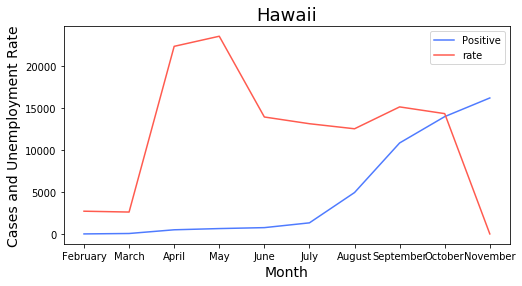

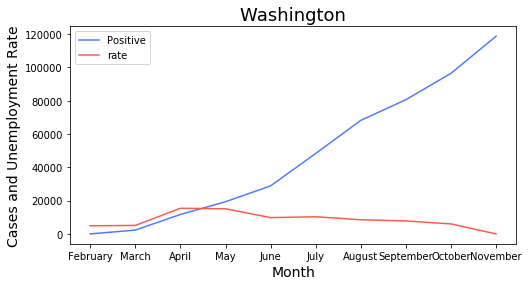

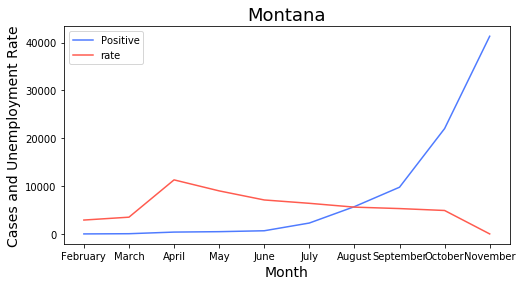

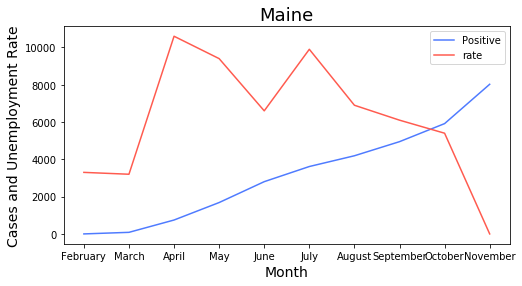

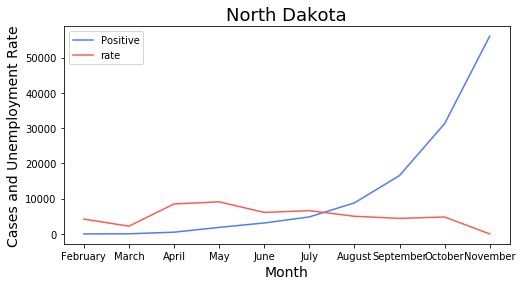

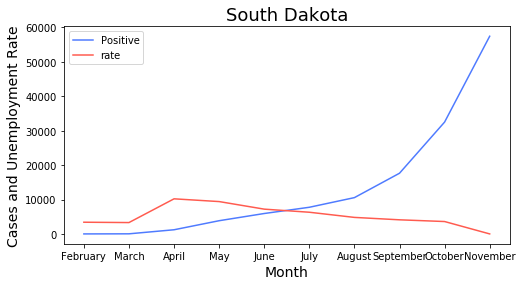

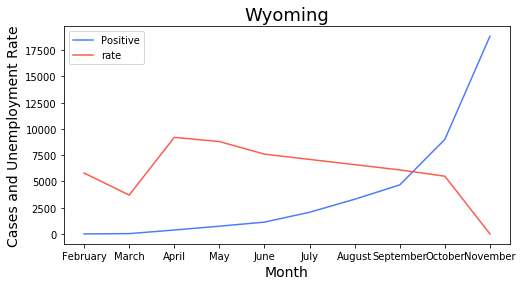

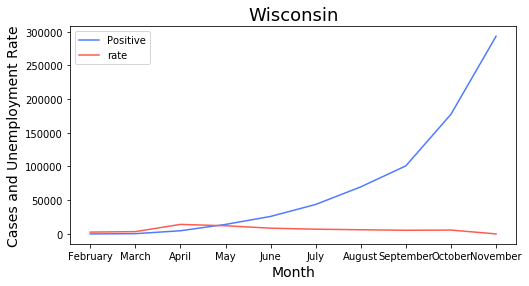

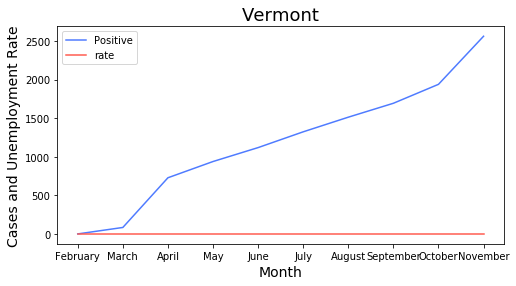

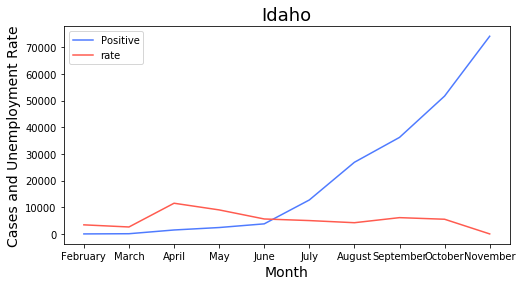

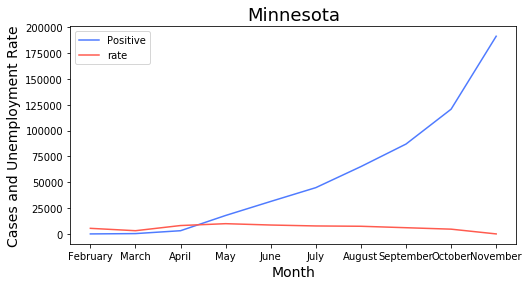

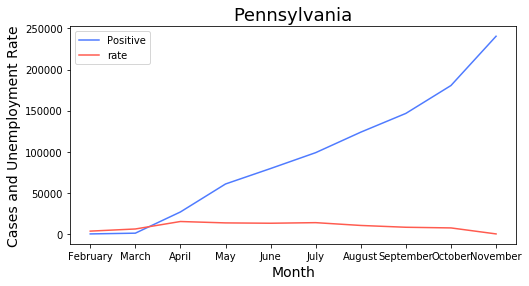

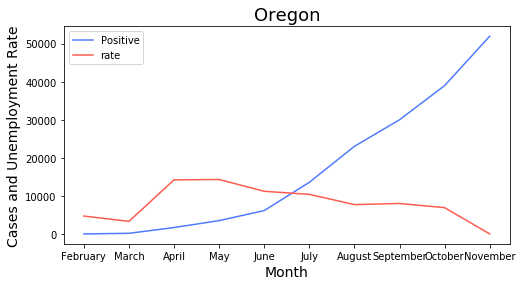

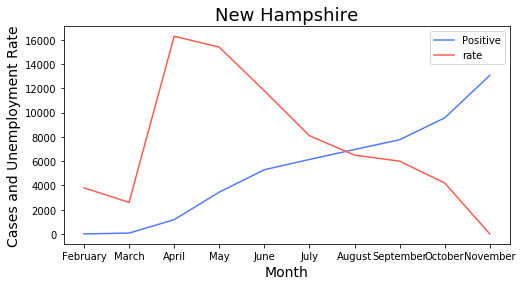

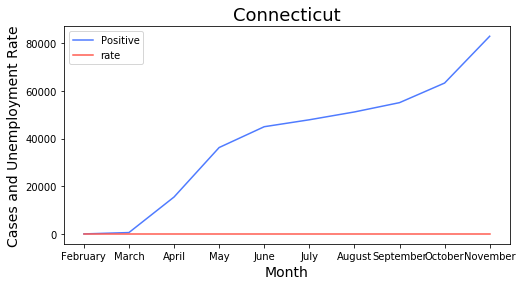

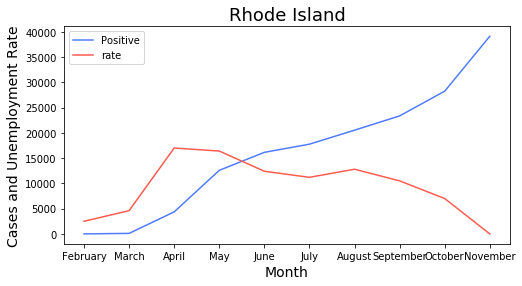

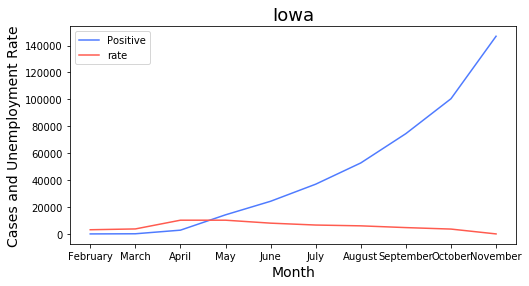

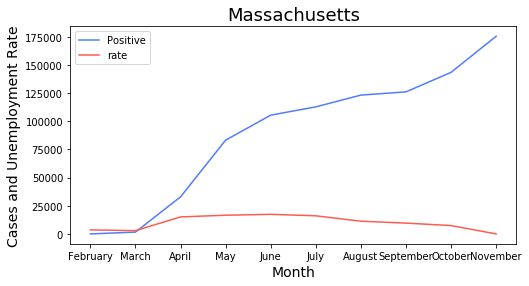

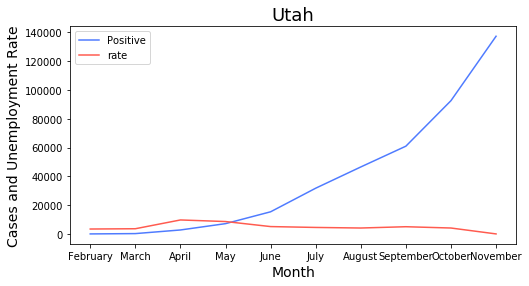

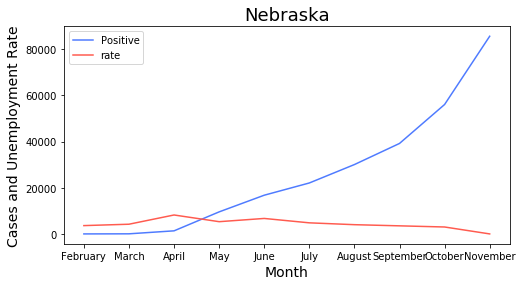

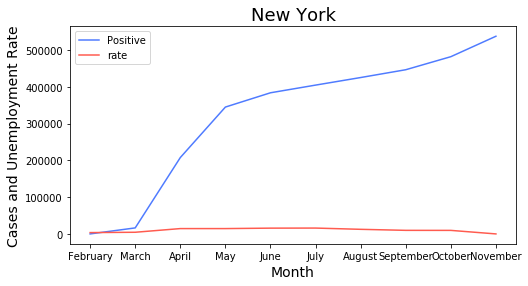

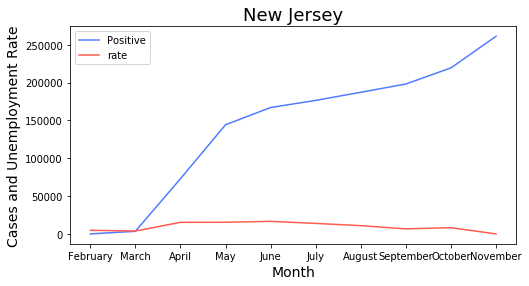

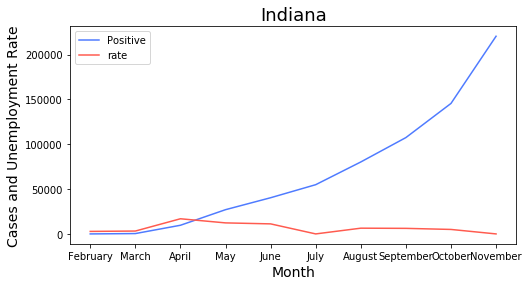

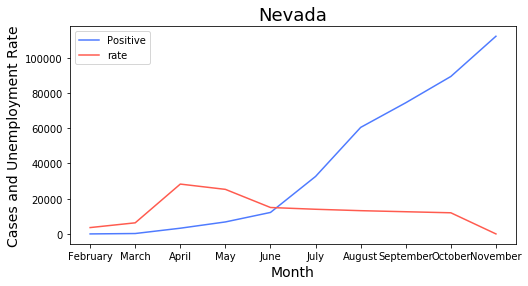

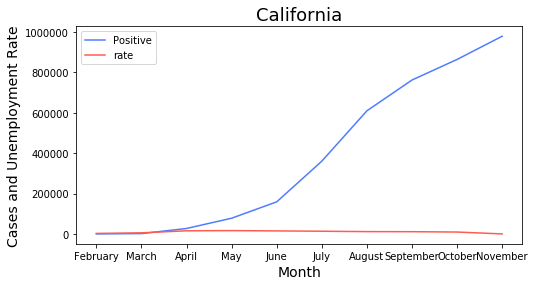

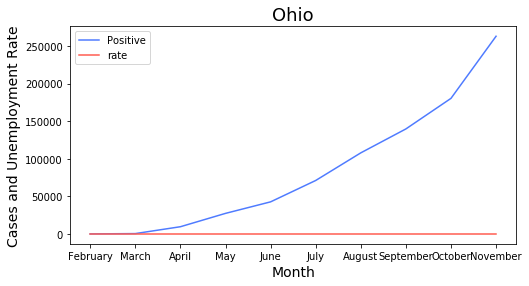

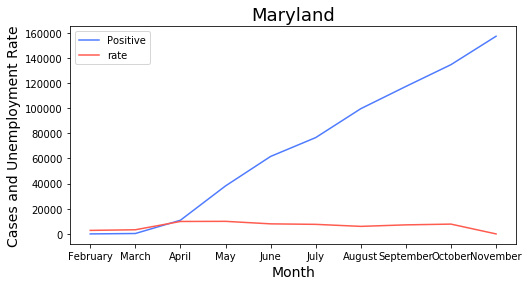

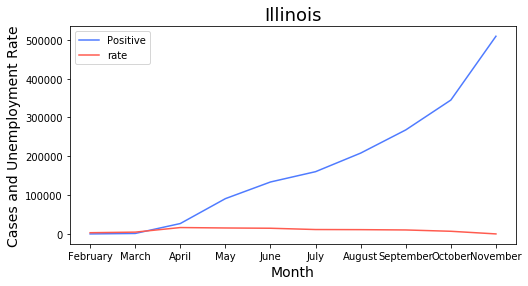

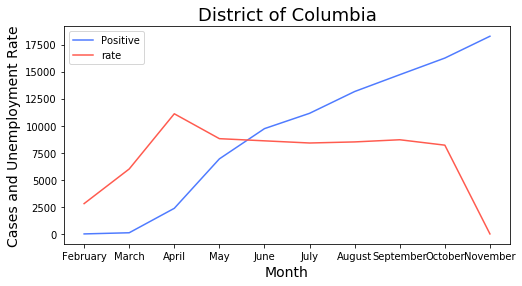

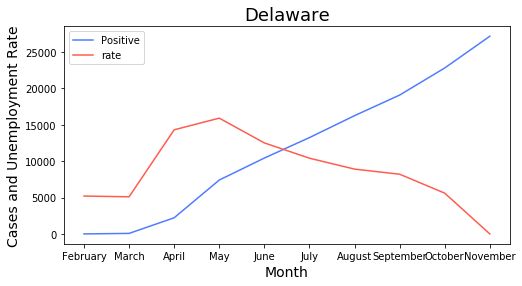

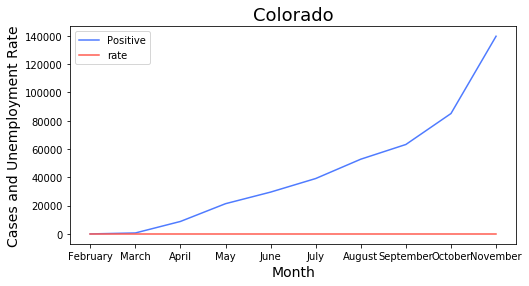

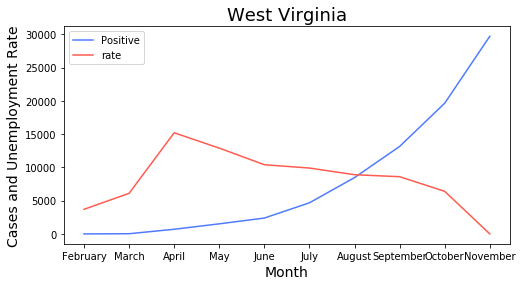

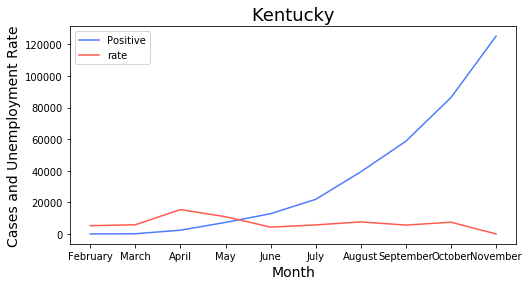

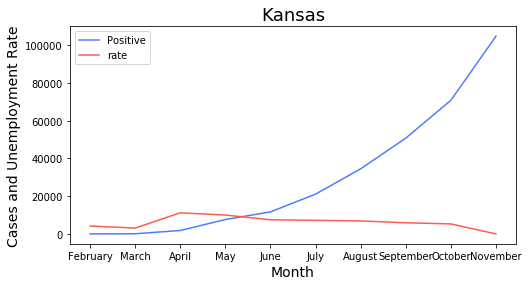

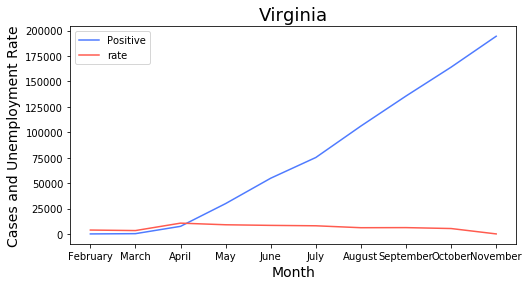

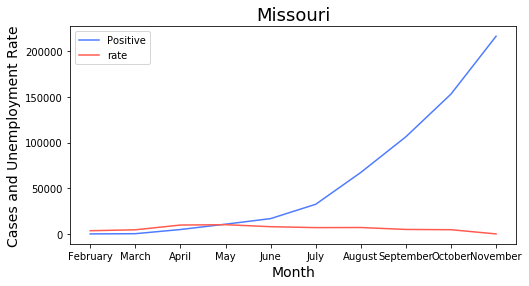

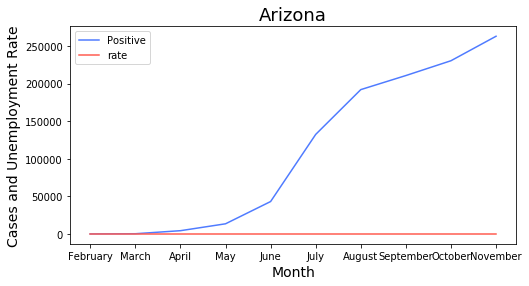

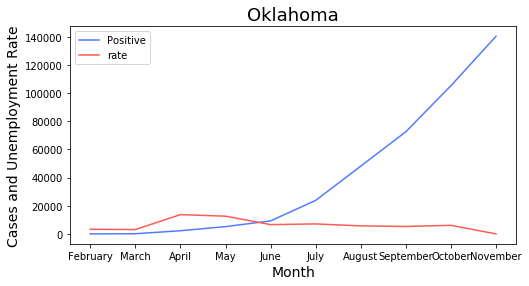

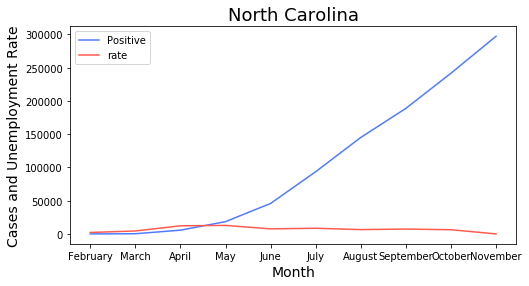

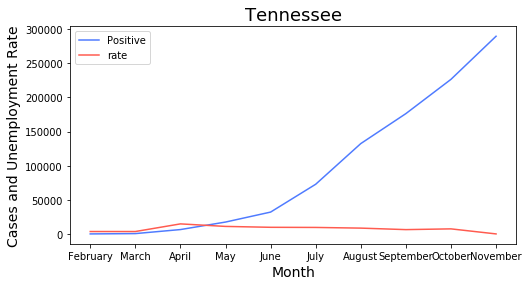

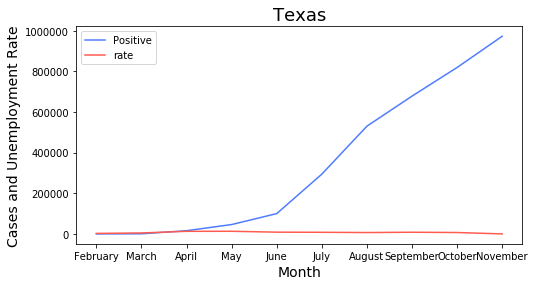

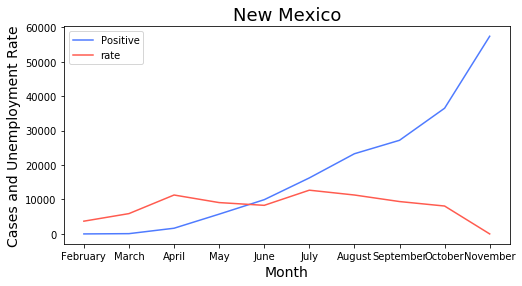

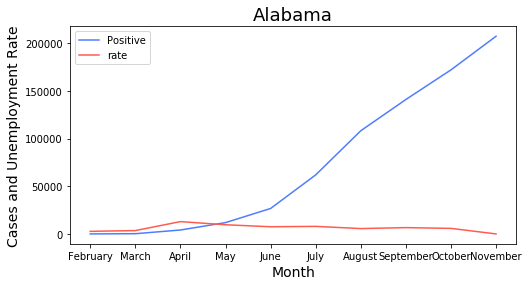

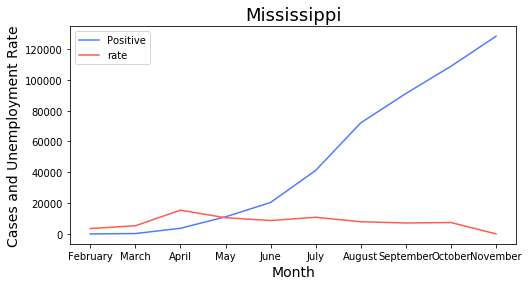

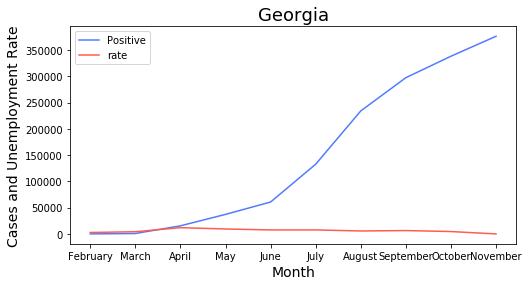

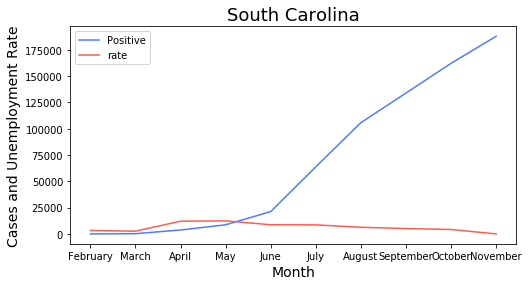

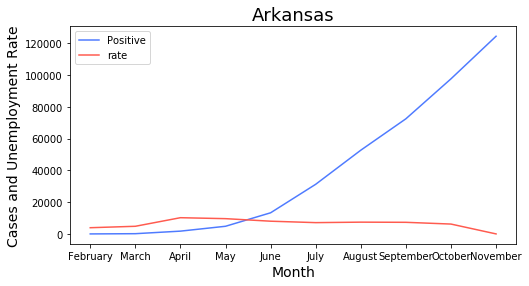

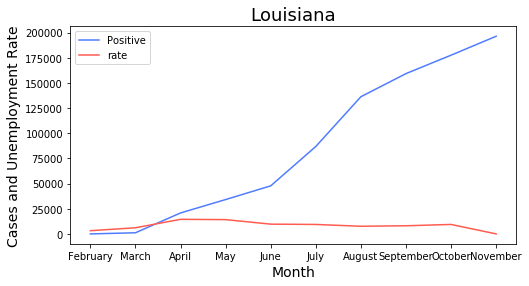

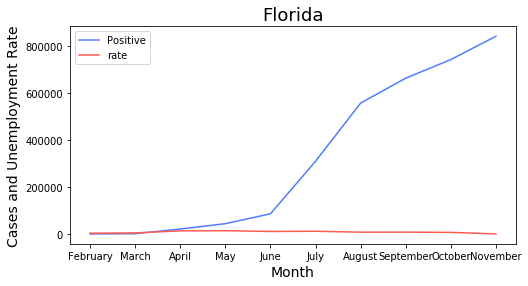

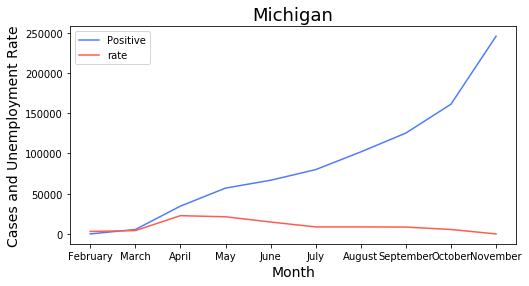

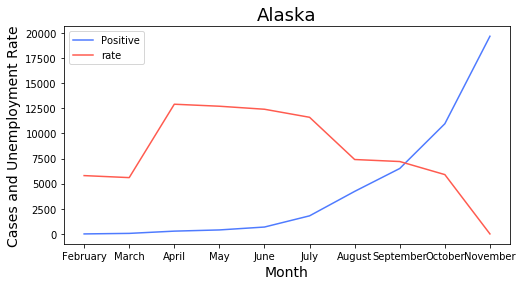

In [38]:
#connect to database
#     db_connection = connect_to_db("127.0.0.1", db_user, db_pwd, db_name)
#     cur = db_connection.cursor()
    
#read us shape to output our national graph 
us_shape = gpd.read_file('States 21basic/geo_export_5a3c36b9-5725-48f7-932f-b261016d93ea.shp')
us_shape = us_shape[['state_name','geometry']]
    
#     cur.callproc("get_election_data")
#     db_connection.commit()
    
#     election = pd.read_sql("select * from result;", con=db_connection)
election = pd.read_csv("./resources/election_by_state.csv" )
states = set(election['state'])
result = {}
for state in states:
    dem = election[(election.Year == 2016) & (election.state == state)]['dem_votes'].values[0]
    rep = election[(election.Year == 2016) & (election.state == state)]['rep_votes'].values[0]
    #print(state,dem)
    result[state] = {'dem':dem, 'rep':rep}
    
def state_style(state,function=False):
    """
    Returns the style for a state in a given year
    """
    
    state_results = result[state]
    
    #Set state colour
    if state_results['dem'] >= state_results['rep']:
        color = '#4f7bff' #blue
    else:
        color = '#ff5b4f' #red
    
    #Set state style
    if function == False:
        # Format for style_dictionary
        state_style = {
            'opacity': 1,
            'color': color,
        } 
    else:
        # Format for style_function
        state_style = {
             'fillOpacity': 1,
             'weight': 1,
             'fillColor': color,
             'color': '#000000'}    

    return state_style

def style_function(feature):
    """
    style_function used by the GeoJson folium function
    """

    state = feature['properties']['state_name']
    style = state_style(state,function=True)
    
    return style


# #plot the choropleth 
# m = folium.Map(location=[50.77500, -100],zoom_start=3)
# choropleth =folium.GeoJson(data= us_shape.to_json(),style_function=style_function)
# m.add_child(choropleth)

results1 = modify_result1("unemployment_rate")

def getFigure(state):
    """
    Plot COVID-19 trends from a given state
    """

    #Get number of cases
    months = ['February','March','April','May','June','July','August','September','October','November']
    pos = []
    rate =[]
    for month in months:

        result = results1[state][month]
        pos.append(result['pos'])  
        rate.append(result['rate']) 

    #Plot number of votes    
    fig = plt.figure(figsize=(8,4))
    plt.plot(months,pos,label='Positive',color='#4f7bff')
    plt.plot(months,rate,label='rate',color='#ff5b4f')

    plt.title(state,size = 18)
    #plt.ticklabel_format(style='plain')
    plt.xlabel('Month',size =14)
    plt.ylabel('Cases and Unemployment Rate',size =14)
    plt.legend(loc =0)

    #Add figure to iframe
    html = mpld3.fig_to_html(fig)
    iframe = folium.IFrame(html=html,width = 600, height = 300)

    return iframe

def highlight_style(feature): 
    """
    style_function for when choropleth button
    is highighted
    """
    return {'fillOpacity': 0.2,
         'weight': 1,
         'fillColor': '#000000',
         'color': '#000000'}

#plot choropleth button map
m = folium.Map(location=[50.77500, -100],zoom_start=3)
choropleth =folium.GeoJson(data= us_shape.to_json(),
                           style_function=style_function)
m.add_child(choropleth)

#Create popup button for each state
for i in range(len(us_shape)):
    
    geometry = us_shape.loc[i]['geometry']
    state_name = us_shape.loc[i]['state_name']
    popup = folium.Popup(getFigure(state_name),max_width=1000)
    
    state_marker = folium.GeoJson(data=mapping(geometry),
                                  highlight_function = highlight_style)
    state_marker.add_child(popup)
    m.add_child(state_marker)

m.save("us_election_map2.html")